In [1]:
import lal
import time
import bilby
import emcee
import pycbc
import corner

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pycbc.waveform as wf
import lalsimulation as lalsim

from scipy.interpolate import interp1d
from pycbc.detector import Detector
from collections import defaultdict
from bilby.core.likelihood import Likelihood

In [42]:
def f22(t_c, q, M):
    G = 6.674e-11
    M = M*1.99e30
    c = 3e8
    eta = q/((1+q)**2)
    return ((5/256/t_c)*(1/eta)*(G*M/c**3)*(np.pi*G*M/(c**3))**(-8/3))**(3/8)

In [45]:
f22(30, 1/10, 16.5)

18.648687590157717

In [6]:
class PSD:
    def __init__(self, psd_filename, prepend_points = [], append_points = [], asd=False):
        self.f_vals, self.psd_vals = np.loadtxt(psd_filename, unpack = True)
        self.prepend_points = prepend_points
        self.append_points = append_points
        self.asd = asd
        for point in self.prepend_points:
            self.f_vals = np.concatenate([np.array([point[0]]), self.f_vals])
            self.psd_vals = np.concatenate([np.array([point[1]]), self.psd_vals])

        for point in self.append_points:
            self.f_vals = np.concatenate([self.f_vals, np.array([point[0]])])
            self.psd_vals = np.concatenate([self.psd_vals, np.array([point[1]])])

        if asd is True:
            self.psd = interp1d(self.f_vals, self.psd_vals**2)
        else:
            self.psd = interp1d(self.f_vals, self.psd_vals)

In [9]:
ligo_H1_psd = '/home/mukesh/Academics/ICTS_gitlab/GWEarlyWarningHM/population_study/data/ligo_O5.txt'
ligo_L1_psd = '/home/mukesh/Academics/ICTS_gitlab/GWEarlyWarningHM/population_study/data/ligo_O5.txt'
ligo_I1_psd = '/home/mukesh/Academics/ICTS_gitlab/GWEarlyWarningHM/population_study/data/ligo_O5.txt'
V1_psd = '/home/mukesh/Academics/ICTS_gitlab/GWEarlyWarningHM/population_study/data/virgo_O5.txt'

H1_psd_int = PSD(ligo_H1_psd, asd=True)
L1_psd_int = PSD(ligo_L1_psd, asd=True)
I1_psd_int = PSD(ligo_I1_psd, asd=True)
V1_psd_int = PSD(V1_psd, prepend_points = [(9, 1e-22)], asd=True)
K1_psd_int = V1_psd_int

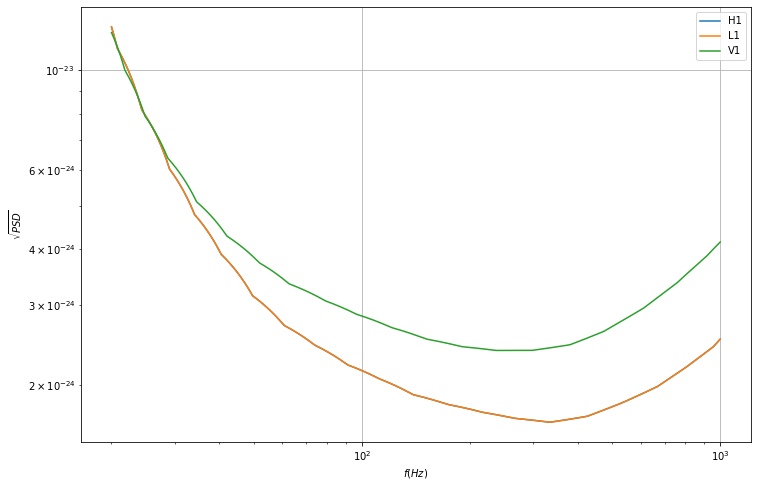

In [10]:
freq = np.linspace(20, 1000, 10000)
plt.figure(figsize=(12,8))
plt.loglog(freq, np.sqrt(H1_psd_int.psd(freq)), label='H1')
plt.loglog(freq, np.sqrt(L1_psd_int.psd(freq)), label='L1')
plt.loglog(freq, np.sqrt(V1_psd_int.psd(freq)), label='V1')
plt.xlabel('$f(Hz)$')
plt.ylabel('$\sqrt{PSD}$')
plt.legend(loc='best')
plt.grid()

In [11]:
def spher_harms_plus_cross_factors(inclination, l, m):
    
    Y_lm = lal.SpinWeightedSphericalHarmonic(inclination, 0, -2, l, m)
    Y_lm_star = np.conj(lal.SpinWeightedSphericalHarmonic(inclination, 0, -2, l, -m))
    
    if (l % 2):
        minus1l = -1
    else:
        minus1l = 1
        
    C_lm =  ( Y_lm + minus1l * Y_lm_star)
    D_lm = -1j * ( Y_lm - minus1l * Y_lm_star)
    
    return C_lm, D_lm

In [12]:
def waveform_lm_mode(fmin, fmax, df, mode, m1, m2, inclination, distance, approx):
    
    mode_array_dict = {
        "22": [[2, 2], [2, -2]],
        "32": [[3, 2], [3, -2]],
        "21": [[2, 1], [2, -1]],
        "44": [[4, 4], [4, -4]],
        "33": [[3, 3], [3, -3]],
        "43": [[4, 3], [4, -3]]
    }
    
    hp, hc = wf.get_fd_waveform(approximant= approx,
                                mass1 = m1, 
                                mass2 = m2, 
                                inclination= inclination,
                                distance = distance,
                                f_lower = fmin,
                                f_final = fmax,
                                delta_f = df,
                                mode_array = mode_array_dict[mode]
                                #coa_phase = coa_phase)
                               )
    # remove the angular dependence through dividing by spherical harmonics
    # so that we have to evaluate instrinsic part only once
    l = int(mode[0])
    m = int(mode[1])
    C_lm, D_lm = spher_harms_plus_cross_factors(inclination, l, m)
    freq = hp.sample_frequencies.data
    hp = hp.data/C_lm
    hc = hc.data/(D_lm)
    h_intrinsic = hp
    return freq, h_intrinsic, hc

In [13]:
# ML estimates for GW170814
mle = dict()
mle["ra"] = 47.75*np.pi/180
mle["dec"] = -np.pi/4
mle["psi"] = 0.0
mle["phi0"] = 0.0
mle["m1"] = 15  #30.6
mle["m2"] = 1.5 #25.2
mle["theta_jn"] = np.pi/3
mle["coa_phase"] = np.pi/4
mle["distance"] = 100.
mle["approx"] = "IMRPhenomXPHM"
mle["geocent_time"] = 1186741861.0
#modes = [ "22"]#, "33", "44"]

In [14]:
def snr(f_array, data, model, detectors):
    snr_det = {}
    snr_sq_net = 0.0
    for det in detectors:
        psd = eval('%s_psd_int.psd(f_array)'%(det))
        snr_sq_integrand = data[det]*np.conjugate(model[det]) / psd
        snr_sq_integral = 4*np.trapz(y=snr_sq_integrand, x=f_array).real
        snr_det[det] = np.sqrt(snr_sq_integral)
        snr_sq_net += snr_sq_integral
    snr_det["network_snr"] = np.sqrt(snr_sq_net)
    return snr_det

In [184]:
def make_data(f_min, df, params, modes, detectors, time_to_merger):
    data = {}
    h_intrinsic = {}
    signal = {}
    mle = params
    f_orb_max = f22(time_to_merger, mle["m1"]/mle["m2"], mle["m1"] + mle["m2"]) / 2
    f_orb_min = 2.5
    f_max = f_orb_max * 4
    for det in detectors:
        signal[det] = 0.0
        Det = Detector(det)
        dt =  Det.time_delay_from_earth_center(mle["ra"], mle["dec"], mle["geocent_time"])
        t_det =  mle["geocent_time"] + dt
        fp, fc = Det.antenna_pattern(mle["ra"], mle["dec"], mle["psi"], mle["geocent_time"])
        
        for mode in modes[0:1]:
            h_intrinsic[mode] = 0.0
            f, h_intrinsic[mode], _ = waveform_lm_mode(f_min, f_max, df, mode, mle["m1"], mle["m2"], mle["theta_jn"], mle["distance"], mle["approx"])
            l = int(mode[0])
            m = int(mode[1])
            
            h_intrinsic[mode][(f < m*f_orb_min)+(f > m*f_orb_max)] = 0.0
            
            lower_index = f >= f_min 
            f = f[lower_index]
            h_intrinsic[mode] = h_intrinsic[mode][lower_index]

            upper_index = f <= f_max
            f = f[upper_index]
            h_intrinsic[mode] = h_intrinsic[mode][upper_index]

            C_lm, D_lm = spher_harms_plus_cross_factors(mle["theta_jn"], l, m)
            phase_shift = (np.cos(2*np.pi*f*t_det + m*mle["phi0"]) + 1j*np.sin(2*np.pi*f*t_det + m*mle["phi0"]))
            signal[det] += (fp*C_lm + fc*D_lm)*h_intrinsic[mode]*phase_shift
    data["frequency_array"] = f
    data["signal"] = signal
    data["intrinsic_part"] = h_intrinsic
    return data

In [185]:
data["signal"]["H1"][-2]

(-2.345273105322171e-25-2.1093844009830314e-25j)

In [186]:
modes = ["22", "33", "44"]
detectors = ["H1", "L1", "V1", "I1", "K1"]
fmin = 10
#fmax = 1000
df = 0.01
data = make_data(fmin, df, mle, modes, detectors, time_to_merger=45)

In [187]:
f_array = data["frequency_array"]

In [188]:
H1_psd = H1_psd_int.psd(f_array)
L1_psd = L1_psd_int.psd(f_array)
V1_psd = V1_psd_int.psd(f_array)

In [189]:
snr_dict = snr(f_array=f_array, data=data["signal"], model=data["signal"], detectors=detectors)
snr_dict

{'H1': 4.010233772277912,
 'L1': 4.432623531897228,
 'V1': 3.9259192485211556,
 'I1': 6.632456819199322,
 'K1': 6.314182352008076,
 'network_snr': 11.619008153138983}

In [183]:
snr_dict = snr(f_array=f_array, data=data["signal"], model=data["signal"], detectors=detectors)
snr_dict

{'H1': 4.234108303064586,
 'L1': 4.680078311271294,
 'V1': 4.183069821549261,
 'I1': 7.002719063915717,
 'K1': 6.727765899513403,
 'network_snr': 12.313804754845377}

In [52]:
def bayestarhm_source_model(frequency_array, intrinsic_signal, det, kwargs, ra, dec):
    #inclination, distance,  psi, geocent_time, phi0,
    #evaluates only extrinsic part of the waveform
    #Intrinsic part of the signal of every mode should be provided as a dictionary    
    Det = Detector(det)
    geocent_time = mle["geocent_time"]
    phi0 = mle["phi0"]
    distance = mle["distance"]
    inclination = mle["theta_jn"]
    #ra = mle["ra"]
    #dec = mle["dec"]
    psi = mle["psi"]
    
    dt = Det.time_delay_from_earth_center(ra, dec, geocent_time)
    t_det =  geocent_time + dt 
    fp, fc = Det.antenna_pattern(ra, dec, psi, geocent_time)
    
    signal_model = 0.0
    phase_shift_t_det = np.cos(2*np.pi*frequency_array*t_det) + 1j*np.sin(2*np.pi*frequency_array*t_det)
    for mode in kwargs["modes"]:
        l = int(mode[0])
        m = int(mode[1])
        C_lm, D_lm = spher_harms_plus_cross_factors(inclination, l, m)
        phase_shift = phase_shift_t_det*(np.cos(m*phi0) + 1j*np.sin(m*phi0))
        signal_model += (fp*C_lm + fc*D_lm)*intrinsic_signal[mode]*phase_shift
            
    return signal_model*(mle["distance"]/distance)

In [53]:
class BayestarHMLikelihood(bilby.Likelihood):
    def __init__(self, f, data, model, params, detectors, modes):
        
        self.f = f
        self.data = data
        self.N = len(f)
        self.model = model
        self.parameters = params
        self.detectors = detectors
        self.modes = modes
        
        self._meta_data = None        
        self._marginalized_parameters = []
        
    def log_likelihood(self):

        waveform_kwargs = {}
        waveform_kwargs["modes"] = self.modes
        frequency_array = self.f
        log_l = 0.0

        #if condition plays the role of prior
        for det in self.detectors:
            template = self.model(frequency_array, self.data["intrinsic_part"], det, waveform_kwargs, **self.parameters)
            likelihood_integrand = abs(self.data["signal"][det] - template)**2
            psd = eval('%s_psd'%(det))
            log_l += -2*np.trapz(likelihood_integrand/psd, frequency_array) 
        return log_l         

In [56]:
#setting up bilby priors
priors = dict(ra=bilby.core.prior.Uniform(0, 2*np.pi, 'ra'),
              dec=bilby.core.prior.Uniform(-np.pi/2, np.pi/2, 'dec'))

outdir = 'outdir1'
livepoints = 1000
walks = 100

In [57]:
parameters = dict(ra=mle["ra"], dec=mle["dec"])

In [58]:
BayestarHM_2d_likelihood = BayestarHMLikelihood(f = f_array, data = data,\
                                                model = bayestarhm_source_model,\
                                                params=parameters, detectors=detectors,\
                                                modes=modes)
result_2D = bilby.run_sampler(
    likelihood=BayestarHM_2d_likelihood, priors=priors, sampler='dynesty', npoints=livepoints,
    walks=walks, outdir=outdir, label='Bayestar_2D_nlive_1000_with_time_dt')

15:22 bilby INFO    : Running for label 'Bayestar_2D_nlive_1000_with_time_dt', output will be saved to 'outdir1'
15:22 bilby INFO    : Search parameters:
15:22 bilby INFO    :   ra = Uniform(minimum=0, maximum=6.283185307179586, name='ra', latex_label='$\\mathrm{RA}$', unit=None, boundary=None)
15:22 bilby INFO    :   dec = Uniform(minimum=-1.5707963267948966, maximum=1.5707963267948966, name='dec', latex_label='$\\mathrm{DEC}$', unit=None, boundary=None)
15:22 bilby INFO    : Single likelihood evaluation took 1.371e-02 s


15:22 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 1000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f0206718c10>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
15:22 bilby INFO    : Checkpoint every check_point_delta_t = 600s
15:22 bilby INFO    : Using dynesty version 1.0.1
15:22 bilby INFO    : Using the bilby-implemented rwalk sa

(array([[0.50278393, 0.63924093],
       [0.93437686, 0.2599117 ],
       [0.48288455, 0.47915493],
       ...,
       [0.16465675, 0.2038676 ],
       [0.74331794, 0.29069275],
       [0.412287  , 0.46683115]]), array([[ 3.15908458,  0.4374383 ],
       [ 5.87086294, -0.75425965],
       [ 3.03405312, -0.06548672],
       ...,
       [ 1.0345689 , -0.93032738],
       [ 4.67040435, -0.65755812],
       [ 2.59047561, -0.10420303]]), array([-148.44777383, -112.95284469, -251.65635744, -280.51422725,
       -277.22643322, -187.67474956, -197.05291292, -348.04711904,
       -199.41825952, -201.92541502, -164.24042454, -331.66415263,
       -132.11625878, -289.96819267, -184.27196384, -131.11521855,
       -209.67536135, -233.45876007, -119.80284786, -223.40015315,
       -270.686403  , -209.03625967, -300.60970333, -124.00211849,
       -100.64472036, -107.15588015, -108.91488746, -169.4207062 ,
       -131.93266491, -156.28402228, -335.318549  , -164.21676504,
       -185.1282144 , -176.

15:32 bilby INFO    : Written checkpoint file outdir1/Bayestar_2D_nlive_1000_with_time_dt_resume.pickle
15:42 bilby INFO    : Written checkpoint file outdir1/Bayestar_2D_nlive_1000_with_time_dt_resume.pickle
15:53 bilby INFO    : Written checkpoint file outdir1/Bayestar_2D_nlive_1000_with_time_dt_resume.pickle
16:03 bilby INFO    : Written checkpoint file outdir1/Bayestar_2D_nlive_1000_with_time_dt_resume.pickle
16:13 bilby INFO    : Written checkpoint file outdir1/Bayestar_2D_nlive_1000_with_time_dt_resume.pickle
16:23 bilby INFO    : Written checkpoint file outdir1/Bayestar_2D_nlive_1000_with_time_dt_resume.pickle
16:33 bilby INFO    : Written checkpoint file outdir1/Bayestar_2D_nlive_1000_with_time_dt_resume.pickle
16:43 bilby INFO    : Written checkpoint file outdir1/Bayestar_2D_nlive_1000_with_time_dt_resume.pickle
16:54 bilby INFO    : Written checkpoint file outdir1/Bayestar_2D_nlive_1000_with_time_dt_resume.pickle
17:04 bilby INFO    : Written checkpoint file outdir1/Bayestar_2

18:39 bilby INFO    : Sampling time: 3:16:59.273148
18:39 bilby INFO    : Summary of results:
nsamples: 13440
ln_noise_evidence:    nan
ln_evidence: -10.086 +/-  0.135
ln_bayes_factor:    nan +/-  0.135



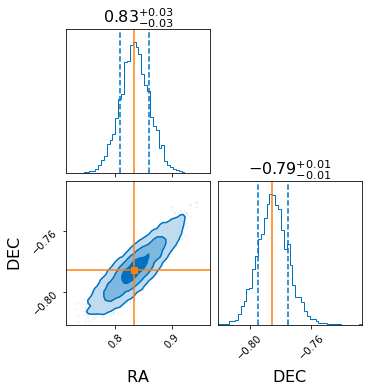

In [59]:
result_2D.plot_corner(truth=dict(ra=mle["ra"], dec = mle["dec"]), titles = True)

In [43]:
mle["dec"], mle["ra"]

(-0.7853981633974483, 0.8333947178272924)

In [44]:
result_2D.nested_samples

ra       dec        weights  log_likelihood
0     2.611872 -1.138747  1.103435e-213     -488.709210
1     2.597107 -1.135602  2.940980e-213     -488.197607
2     2.634078 -1.255590  7.413040e-211     -482.199708
3     2.772885 -0.936837  1.024761e-209     -479.644657
4     2.811140 -1.139914  2.542563e-209     -479.127916
...        ...       ...            ...             ...
9306  0.830862 -0.781841   9.538379e-05       -0.000906
9307  0.831059 -0.782483   9.539267e-05       -0.000737
9308  0.835525 -0.785191   9.540410e-05       -0.000666
9309  0.831430 -0.784230   9.541599e-05       -0.000487
9310  0.832726 -0.782735   9.543790e-05       -0.000207

[9311 rows x 4 columns]

In [63]:
result_2D.plot_marginals(parameters=parameters, quantiles=[0.05, 0.95])

18:45 bilby INFO    : Plotting ra marginal distribution
18:45 bilby INFO    : Plotting ra marginal distribution
18:45 bilby INFO    : Plotting dec marginal distribution
18:45 bilby INFO    : Plotting dec marginal distribution


In [66]:
bilby.core.prior.Sine?

Init signature:
bilby.core.prior.Sine(
    minimum=0,
    maximum=3.141592653589793,
    name=None,
    latex_label=None,
    unit=None,
    boundary=None,
)
Docstring:      <no docstring>
Init docstring:
Sine prior with bounds

Parameters
minimum: float
    See superclass
maximum: float
    See superclass
name: str
    See superclass
latex_label: str
    See superclass
unit: str
    See superclass
boundary: str
    See superclass
File:           ~/anaconda3/envs/pycbc/lib/python3.7/site-packages/bilby/core/prior/analytical.py
Type:           type
Subclasses:     ConditionalPrior


In [67]:
bilby.gw.prior.UniformComovingVolume?

Init signature:
bilby.gw.prior.UniformComovingVolume(
    minimum,
    maximum,
    cosmology=None,
    name=None,
    latex_label=None,
    unit=None,
    boundary=None,
)
Docstring:      <no docstring>
Init docstring:
Creates an interpolated prior function from arrays of xx and yy=p(xx)

Parameters
xx: array_like
    x values for the to be interpolated prior function
yy: array_like
    p(xx) values for the to be interpolated prior function
minimum: float
    See superclass
maximum: float
    See superclass
name: str
    See superclass
latex_label: str
    See superclass
unit: str
    See superclass
boundary: str
    See superclass

Attributes
probability_density: scipy.interpolate.interp1d
    Interpolated prior probability distribution
cumulative_distribution: scipy.interpolate.interp1d
    Interpolated cumulative prior probability distribution
inverse_cumulative_distribution: scipy.interpolate.interp1d
    Inverted cumulative prior probability distribution
YY: array_like
    Cumula

In [68]:
2*np.pi

6.283185307179586

In [70]:
result_MCMC = bilby.run_sampler(BayestarHM_2d_likelihood, priors=priors, sampler="bilby_mcmc",\
                                nsamples=1000, plot=True, outdir="outdir_mcmc", label="2d_mcmc")

10:12 bilby INFO    : Running for label '2d_mcmc', output will be saved to 'outdir_mcmc'
10:12 bilby INFO    : Search parameters:
10:12 bilby INFO    :   ra = Uniform(minimum=0, maximum=6.283185307179586, name='ra', latex_label='$\\mathrm{RA}$', unit=None, boundary=None)
10:12 bilby INFO    :   dec = Uniform(minimum=-1.5707963267948966, maximum=1.5707963267948966, name='dec', latex_label='$\\mathrm{DEC}$', unit=None, boundary=None)
10:12 bilby INFO    : Single likelihood evaluation took 1.219e-02 s
10:12 bilby INFO    : Using sampler Bilby_MCMC with kwargs {'nsamples': 1000, 'nensemble': 1, 'pt_ensemble': False, 'ntemps': 1, 'Tmax': None, 'Tmax_from_SNR': 20, 'initial_betas': None, 'adapt': True, 'adapt_t0': 100, 'adapt_nu': 10, 'pt_rejection_sample': False, 'burn_in_nact': 10, 'thin_by_nact': 1, 'fixed_discard': 0, 'autocorr_c': 5, 'L1steps': 100, 'L2steps': 3, 'npool': 1, 'printdt': 60, 'min_tau': 1, 'proposal_cycle': 'default', 'stop_after_convergence': False, 'fixed_tau': None, 'ta

TypeError: bayestarhm_source_model() got an unexpected keyword argument 'logl'

In [69]:
bilby.run_sampler?

Signature:
bilby.run_sampler(
    likelihood,
    priors=None,
    label='label',
    outdir='outdir',
    sampler='dynesty',
    use_ratio=None,
    injection_parameters=None,
    conversion_function=None,
    plot=False,
    default_priors_file=None,
    clean=None,
    meta_data=None,
    save=True,
    gzip=False,
    result_class=None,
    npool=1,
    **kwargs,
)
Docstring:
The primary interface to easy parameter estimation

Parameters
likelihood: `bilby.Likelihood`
    A `Likelihood` instance
priors: `bilby.PriorDict`
    A PriorDict/dictionary of the priors for each parameter - missing
    parameters will use default priors, if None, all priors will be default
label: str
    Name for the run, used in output files
outdir: str
    A string used in defining output files
sampler: str, Sampler
    The name of the sampler to use - see
    `bilby.sampler.get_implemented_samplers()` for a list of available
    samplers.
    Alternatively a Sampler object can be passed
use_ratio: bool (